In [1]:
import matplotlib.pyplot as plt
import datetime
import mxnet as mx
import mxnet.gluon as gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn
from mxnet.gluon.data import DataLoader
from mxnet import autograd
from mxnet import init
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [2]:
def transform(data, label):
    return nd.transpose(data.astype('float32'), (2, 0, 1))/255, label.astype('float32')
mnist_train = gluon.data.vision.FashionMNIST(train=True, transform=transform)
mnist_test = gluon.data.vision.FashionMNIST(train=False, transform=transform)

In [3]:
ctx = mx.gpu(1)
# ctx = mx.cpu()
batch_size = 256
train_data = gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)
test_data = gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)

In [4]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()


def evaluate_accuracy(data_iterator, net, ctx=ctx):
    acc, loss = 0.0, 0.0
    for data, label in data_iterator:
        label = label.as_in_context(ctx)
        acc += accuracy(net(data.as_in_context(ctx)), label)
        loss += nd.mean(softmax_cross_entropy(net(data.as_in_context(ctx)), label)).asscalar()
    return acc / len(data_iterator), loss / len(data_iterator)

# Fully connect dense neural network

In [5]:
net = nn.Sequential()

In [6]:
with net.name_scope():
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(256, activation="relu"))
    net.add(gluon.nn.Dense(10))
net.initialize(ctx=ctx, init=init.Xavier())

In [7]:
lr = 0.5
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

train_loss_array = []
test_loss_array = []
train_acc_array = []
test_acc_array = []
for epoch in range(10):
    train_loss = 0.
    train_acc = 0.
    prev_time = datetime.datetime.now()
    for data, label in train_data:
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)
    test_acc, test_loss = evaluate_accuracy(test_data, net)
    cur_time = datetime.datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    prev_time = cur_time
    train_loss_array.append(train_loss/len(train_data))
    train_acc_array.append(train_acc/len(train_data))
    test_loss_array.append(test_loss)
    test_acc_array.append(test_acc)
    print("Epoch %d. Train loss: %f, Train acc %.2f%%, Test loss %f, Test acc %.2f%%, Time %s, lr %s" % (
        epoch, train_loss/len(train_data), train_acc/len(train_data) * 100, test_loss, test_acc * 100, time_str, str(lr)))

Epoch 0. Train loss: 0.754354, Train acc 72.95%, Test loss 0.482594, Test acc 81.97%, Time 00:00:36, lr 0.5
Epoch 1. Train loss: 0.471233, Train acc 82.63%, Test loss 0.402951, Test acc 85.22%, Time 00:00:13, lr 0.5
Epoch 2. Train loss: 0.414088, Train acc 84.72%, Test loss 0.373534, Test acc 86.37%, Time 00:00:13, lr 0.5
Epoch 3. Train loss: 0.385633, Train acc 85.95%, Test loss 0.388035, Test acc 86.52%, Time 00:00:13, lr 0.5
Epoch 4. Train loss: 0.362919, Train acc 86.77%, Test loss 0.344128, Test acc 87.45%, Time 00:00:13, lr 0.5
Epoch 5. Train loss: 0.349117, Train acc 87.09%, Test loss 0.326610, Test acc 88.17%, Time 00:00:13, lr 0.5
Epoch 6. Train loss: 0.330611, Train acc 87.86%, Test loss 0.335690, Test acc 87.77%, Time 00:00:13, lr 0.5
Epoch 7. Train loss: 0.318621, Train acc 88.40%, Test loss 0.324203, Test acc 88.08%, Time 00:00:13, lr 0.5
Epoch 8. Train loss: 0.310120, Train acc 88.55%, Test loss 0.331993, Test acc 87.74%, Time 00:00:13, lr 0.5
Epoch 9. Train loss: 0.30033

In [8]:
print(net)

Sequential(
  (0): Flatten
  (1): Dense(784 -> 256, Activation(relu))
  (2): Dense(256 -> 10, linear)
)


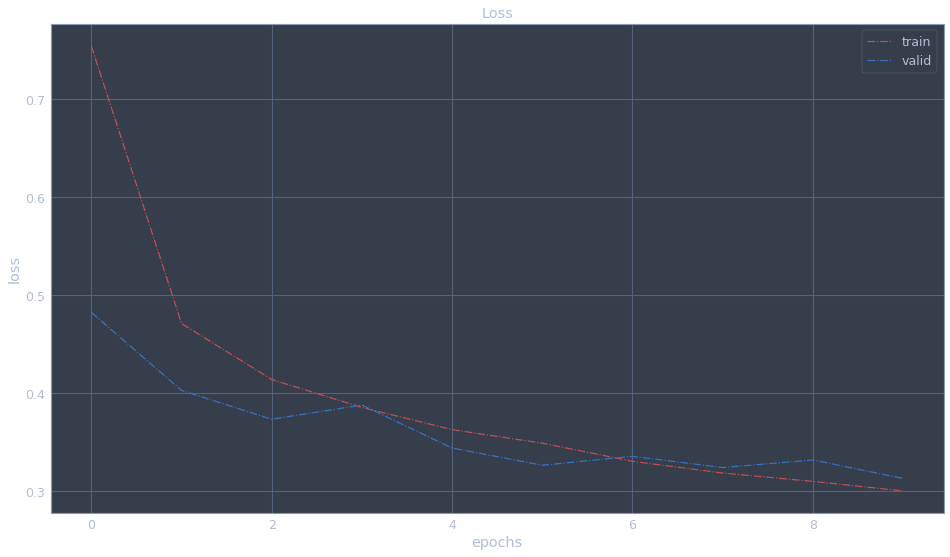

In [9]:
plt.figure(figsize=(16, 9))
plt.plot(train_loss_array, 'r-.',test_loss_array, 'b-.')
plt.legend(['train', 'valid'])
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

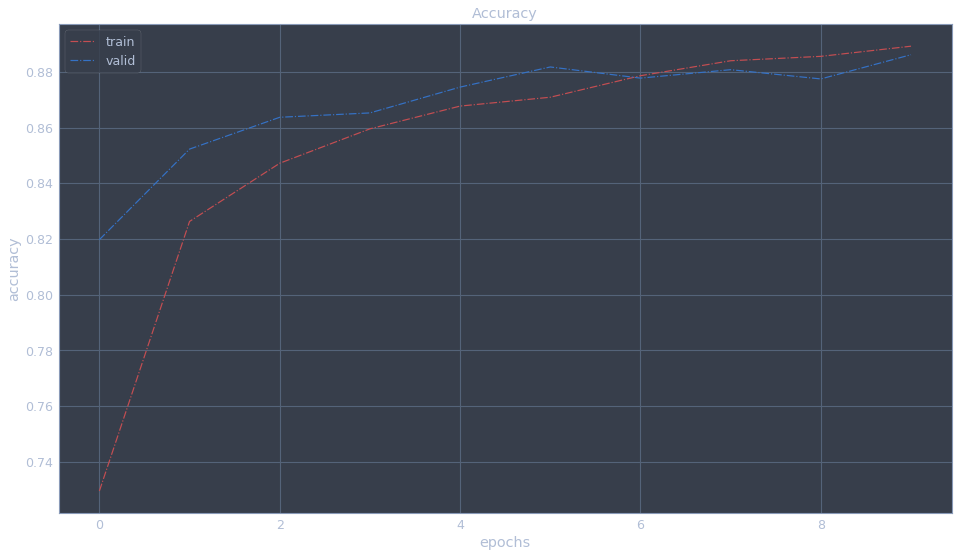

In [10]:
plt.figure(figsize=(16, 9))
plt.plot(train_acc_array, 'r-.',test_acc_array, 'b-.')
plt.legend(['train', 'valid'])
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# CNN-LeNet

In [11]:
cnn_net = nn.Sequential()
with cnn_net.name_scope():
    cnn_net.add(nn.Conv2D(channels=20, kernel_size=5, activation='relu'),
                nn.MaxPool2D(pool_size=2, strides=2),
                nn.Conv2D(channels=50, kernel_size=3, activation='relu'),
                nn.MaxPool2D(pool_size=2, strides=2),
                nn.Flatten(),
                nn.Dense(128, activation='relu'),
                nn.Dense(10))

cnn_net.initialize(ctx=ctx, init=init.Xavier())

In [12]:
lr = 0.5
trainer = gluon.Trainer(cnn_net.collect_params(), 'sgd', {'learning_rate': lr})

train_loss_array = []
test_loss_array = []
train_acc_array = []
test_acc_array = []
for epoch in range(10):
    train_loss = 0.0
    train_acc = 0.0
    prev_time = datetime.datetime.now()
    for data, label in train_data:
#         data = nd.transpose(data.astype('float32'), (0, 3, 1, 2)) / 255
        label = label.as_in_context(ctx)
        with autograd.record():
            output = cnn_net(data.as_in_context(ctx))
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)
    test_acc, test_loss = evaluate_accuracy(test_data, cnn_net)
    cur_time = datetime.datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    prev_time = cur_time
    train_loss_array.append(train_loss/len(train_data))
    train_acc_array.append(train_acc/len(train_data))
    test_loss_array.append(test_loss)
    test_acc_array.append(test_acc)
    print("Epoch %d. Train loss: %f, Train acc %.2f%%, Test loss %f, Test acc %.2f%%, Time %s, lr %s" % (
        epoch, train_loss/len(train_data), train_acc/len(train_data) * 100, test_loss, test_acc * 100, time_str, str(lr)))

Epoch 0. Train loss: 1.349075, Train acc 49.71%, Test loss 0.594440, Test acc 76.93%, Time 00:00:13, lr 0.5
Epoch 1. Train loss: 0.537305, Train acc 79.11%, Test loss 0.461967, Test acc 82.58%, Time 00:00:14, lr 0.5
Epoch 2. Train loss: 0.444501, Train acc 83.18%, Test loss 0.384413, Test acc 85.70%, Time 00:00:14, lr 0.5
Epoch 3. Train loss: 0.397666, Train acc 85.00%, Test loss 0.360156, Test acc 86.21%, Time 00:00:14, lr 0.5
Epoch 4. Train loss: 0.366510, Train acc 86.10%, Test loss 0.337225, Test acc 87.79%, Time 00:00:14, lr 0.5
Epoch 5. Train loss: 0.340049, Train acc 87.04%, Test loss 0.317662, Test acc 88.06%, Time 00:00:13, lr 0.5
Epoch 6. Train loss: 0.318041, Train acc 88.03%, Test loss 0.307107, Test acc 88.54%, Time 00:00:13, lr 0.5
Epoch 7. Train loss: 0.300937, Train acc 88.66%, Test loss 0.301320, Test acc 88.71%, Time 00:00:13, lr 0.5
Epoch 8. Train loss: 0.287353, Train acc 89.19%, Test loss 0.297521, Test acc 88.81%, Time 00:00:13, lr 0.5
Epoch 9. Train loss: 0.27426

In [13]:
print(cnn_net)

Sequential(
  (0): Conv2D(1 -> 20, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(20 -> 50, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): Flatten
  (5): Dense(1250 -> 128, Activation(relu))
  (6): Dense(128 -> 10, linear)
)


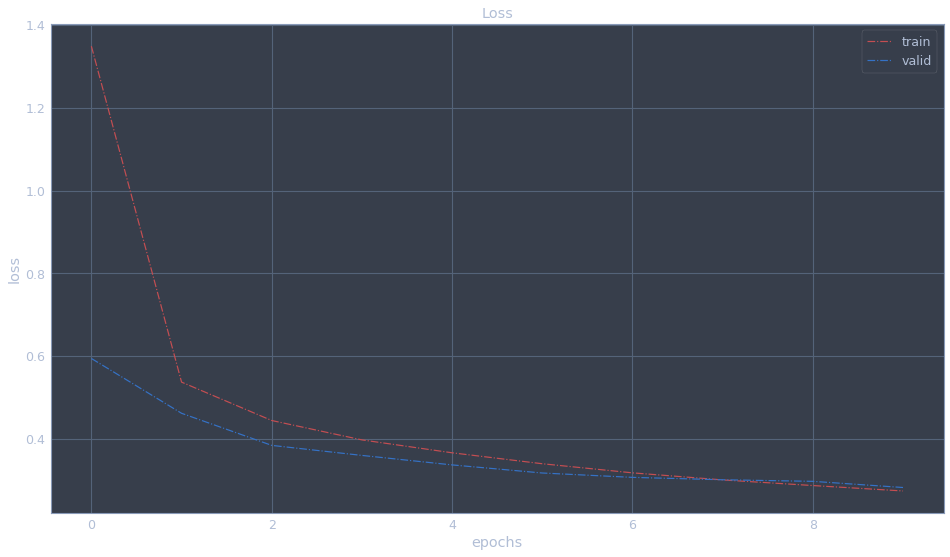

In [14]:
plt.figure(figsize=(16, 9))
plt.plot(train_loss_array, 'r-.',test_loss_array, 'b-.')
plt.legend(['train', 'valid'])
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

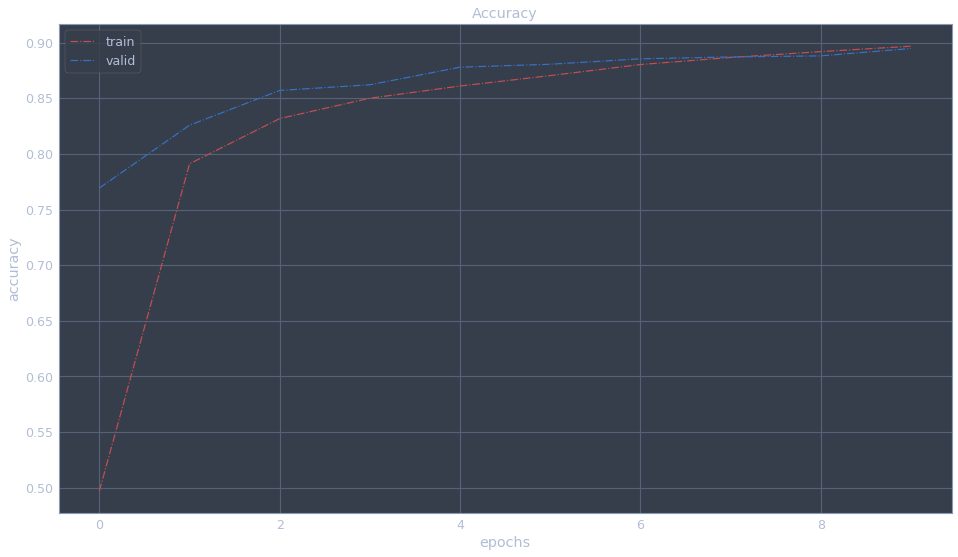

In [15]:
plt.figure(figsize=(16, 9))
plt.plot(train_acc_array, 'r-.',test_acc_array, 'b-.')
plt.legend(['train', 'valid'])
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# CNN-AlexNet

In [16]:
alex = nn.Sequential()

In [17]:
with alex.name_scope():
    alex.add(nn.Conv2D(channels=96, kernel_size=5, strides=1, activation='relu'),
             nn.MaxPool2D(pool_size=2, strides=2),
             nn.Conv2D(channels=256, kernel_size=3, strides=1, activation='relu'),
             nn.MaxPool2D(pool_size=2, strides=1),
             nn.Conv2D(channels=384, kernel_size=3, strides=1, activation='relu'),
             nn.Conv2D(channels=384, kernel_size=3, strides=1, activation='relu'),
             nn.Conv2D(channels=256, kernel_size=3, strides=1, activation='relu'),
             nn.MaxPool2D(pool_size=2, strides=1),
             nn.Flatten(),
             nn.Dense(units=4096, activation='relu'),
             nn.Dropout(0.5),
             nn.Dense(units=4096, activation='relu'),
             nn.Dropout(0.5),
             nn.Dense(units=10)
             )

In [18]:
alex.initialize(ctx=ctx, init=init.Xavier())

In [19]:
lr = 0.01
trainer = gluon.Trainer(alex.collect_params(), 'sgd', {'learning_rate': lr})

train_loss_array = []
test_loss_array = []
train_acc_array = []
test_acc_array = []

for epoch in range(100):
    train_loss, train_acc = 0.0, 0.0
    prev_time = datetime.datetime.now()
    for data, label in train_data:
        label = label.as_in_context(ctx)
        with autograd.record():
            output = alex(data.as_in_context(ctx))
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)
    test_acc, test_loss = evaluate_accuracy(test_data, alex)
    cur_time = datetime.datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    prev_time = cur_time
    train_loss_array.append(train_loss/len(train_data))
    train_acc_array.append(train_acc/len(train_data))
    test_loss_array.append(test_loss)
    test_acc_array.append(test_acc)
    print("Epoch %d. Train loss: %f, Train acc %.2f%%, Test loss %f, Test acc %.2f%%, Time %s, lr %s" % (
        epoch, train_loss/len(train_data), train_acc/len(train_data) * 100, test_loss, test_acc * 100, time_str, str(lr)))

Epoch 0. Train loss: 2.295093, Train acc 17.63%, Test loss 2.281328, Test acc 40.74%, Time 00:00:25, lr 0.01
Epoch 1. Train loss: 2.191611, Train acc 30.15%, Test loss 1.666771, Test acc 41.04%, Time 00:00:22, lr 0.01
Epoch 2. Train loss: 1.314698, Train acc 48.90%, Test loss 0.976801, Test acc 64.57%, Time 00:00:24, lr 0.01
Epoch 3. Train loss: 0.986128, Train acc 62.29%, Test loss 0.835410, Test acc 69.38%, Time 00:00:24, lr 0.01
Epoch 4. Train loss: 0.841878, Train acc 68.05%, Test loss 0.753154, Test acc 71.76%, Time 00:00:23, lr 0.01
Epoch 5. Train loss: 0.765978, Train acc 70.71%, Test loss 0.705668, Test acc 73.34%, Time 00:00:23, lr 0.01
Epoch 6. Train loss: 0.716560, Train acc 72.57%, Test loss 0.664146, Test acc 74.92%, Time 00:00:22, lr 0.01
Epoch 7. Train loss: 0.680070, Train acc 73.83%, Test loss 0.629323, Test acc 76.88%, Time 00:00:24, lr 0.01
Epoch 8. Train loss: 0.654408, Train acc 74.85%, Test loss 0.603366, Test acc 77.91%, Time 00:00:23, lr 0.01
Epoch 9. Train loss

Epoch 75. Train loss: 0.258892, Train acc 90.47%, Test loss 0.268226, Test acc 89.86%, Time 00:00:23, lr 0.01
Epoch 76. Train loss: 0.256132, Train acc 90.56%, Test loss 0.264851, Test acc 90.38%, Time 00:00:25, lr 0.01
Epoch 77. Train loss: 0.254664, Train acc 90.60%, Test loss 0.270658, Test acc 89.85%, Time 00:00:24, lr 0.01
Epoch 78. Train loss: 0.253474, Train acc 90.63%, Test loss 0.271791, Test acc 90.12%, Time 00:00:24, lr 0.01
Epoch 79. Train loss: 0.249691, Train acc 90.81%, Test loss 0.266901, Test acc 90.17%, Time 00:00:22, lr 0.01
Epoch 80. Train loss: 0.250037, Train acc 90.76%, Test loss 0.261565, Test acc 89.90%, Time 00:00:23, lr 0.01
Epoch 81. Train loss: 0.248964, Train acc 90.81%, Test loss 0.258465, Test acc 90.45%, Time 00:00:23, lr 0.01
Epoch 82. Train loss: 0.247089, Train acc 90.85%, Test loss 0.257898, Test acc 90.56%, Time 00:00:24, lr 0.01
Epoch 83. Train loss: 0.243421, Train acc 90.94%, Test loss 0.260061, Test acc 90.66%, Time 00:00:23, lr 0.01
Epoch 84. 

In [20]:
print(alex)

Sequential(
  (0): Conv2D(1 -> 96, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(96 -> 256, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2D(size=(2, 2), stride=(1, 1), padding=(0, 0), ceil_mode=False)
  (4): Conv2D(256 -> 384, kernel_size=(3, 3), stride=(1, 1))
  (5): Conv2D(384 -> 384, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2D(384 -> 256, kernel_size=(3, 3), stride=(1, 1))
  (7): MaxPool2D(size=(2, 2), stride=(1, 1), padding=(0, 0), ceil_mode=False)
  (8): Flatten
  (9): Dense(1024 -> 4096, Activation(relu))
  (10): Dropout(p = 0.5)
  (11): Dense(4096 -> 4096, Activation(relu))
  (12): Dropout(p = 0.5)
  (13): Dense(4096 -> 10, linear)
)


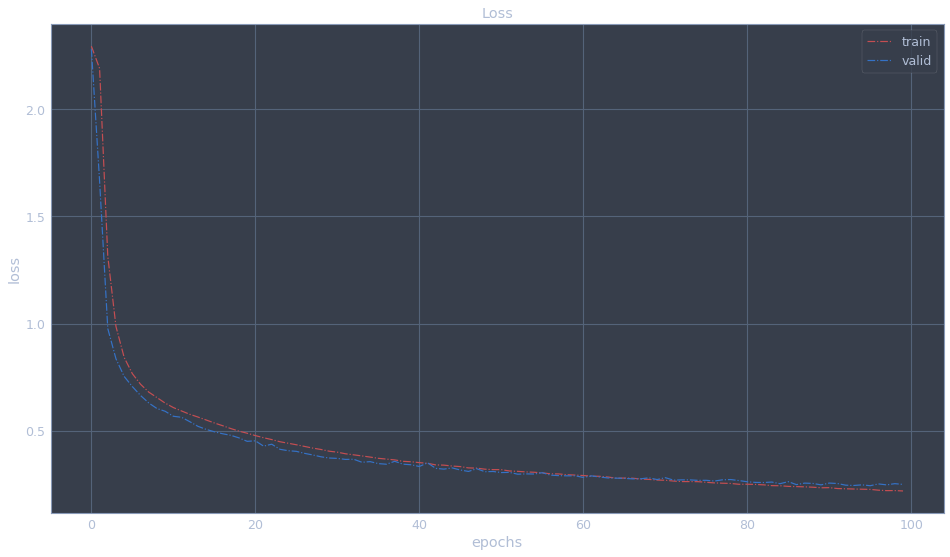

In [21]:
plt.figure(figsize=(16, 9))
plt.plot(train_loss_array, 'r-.',test_loss_array, 'b-.')
plt.legend(['train', 'valid'])
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

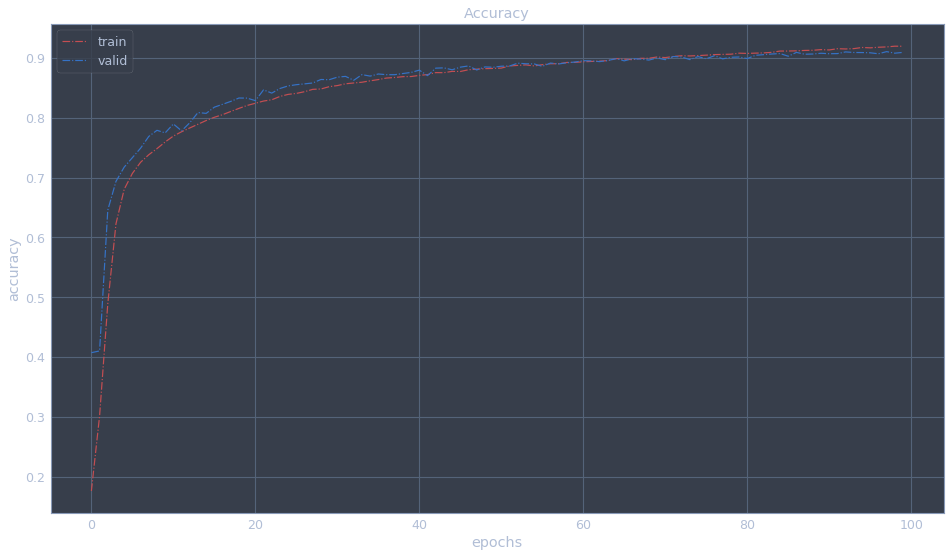

In [22]:
plt.figure(figsize=(16, 9))
plt.plot(train_acc_array, 'r-.',test_acc_array, 'b-.')
plt.legend(['train', 'valid'])
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()